# Morris screening

Consider a model of the sort $Y=h(X)$, $Y$ is assumed to be scalar, $X=[X_{1}, ..., X_{d}]$.

For each input $X_{k}$, the elementary effect is computed as:
\begin{equation*}
EE_{k} = \frac{Y(X_{1}, ..., X_{k}+\Delta, ..., X_{d})-Y(X_{1}, ..., X_{k}, ..., X_{d})}{\Delta}
\end{equation*}
where $\Delta$ is chosen so that $X_{k}+\Delta$ is still in the allowable domain for every dimension $k$.

The key idea of the original Morris method is to initiate trajectories from various “nominal” points X randomly selected over the grid and then gradually advancing one $\Delta$ at a time between each model evaluation (one at a time OAT design), along a different dimension of the parameter space selected randomly. For $r$ trajectories (usually set $r$ between 5 and 50), the number of simulations required is $r (d+1)$.

Sensitivity indices are computed as:
\begin{equation*}
\mu_{k}^{\star} = \frac{1}{r} \sum_{i=1}^{r} \vert EE_{k}^{r} \vert
\end{equation*}
\begin{equation*}
\sigma_{k} = \sqrt{ \frac{1}{r} \sum_{i=1}^{r} \left( EE_{k}^{r} - \mu_{k} \right)^{2}}
\end{equation*}

It allows differentiation between three groups of inputs:
- Parameters with noninfluential effects, i.e., the parameters that have relatively small values of both $\mu_{k}^{\star}$ and $\sigma_{k}$.
- Parameters with linear and/or additive effects, i.e., the parameters that have a relatively large value of $\mu_{k}^{\star}$ and relatively small value of $\sigma_{k}$ (the magnitude of the effect $\mu_{k}^{\star}$ is consistently large, regardless of the other parameter values, i.e., no interaction).
- Parameters with nonlinear and/or interaction effects, i.e., the parameters that have a relatively small value of $\mu_{k}^{\star}$ and a relatively large value of $\sigma_{k}$ (large value of $\sigma_{k}$ indicates that the effect can be large or small depending on the other values of parameters at which the model is evaluated, indicates potential interaction between parameters).


In [1]:
from UQpy.RunModel import RunModel
from UQpy.distributions import Uniform
from UQpy.sensitivity import MorrisSensitivity
import numpy as np
import matplotlib.pyplot as plt

## Test on 2-dimensional g-function

In [2]:
# Set-up problem with g function
a_values = [0.001, 99.]
na = len(a_values)

var_names = ['X{}'.format(i) for i in range(na)]
runmodel_object = RunModel(
    model_script='pfn.py', model_object_name='gfun_sensitivity', var_names=var_names, vec=True,
    a_values=a_values)

dist_object = [Uniform(), ] * na

First plot contour of the function, clearly X2 has little influence on the function compared to X1

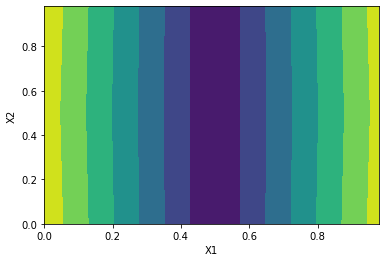

In [3]:
x = np.arange(0, 1, 0.02)
y = np.arange(0, 1, 0.02)
xx, yy = np.meshgrid(x, y, sparse=False)
runmodel_object.run(samples=np.vstack([xx.reshape((-1,)), yy.reshape((-1,))]).T, append_samples=False)
h = plt.contourf(x, y, np.array(runmodel_object.qoi_list).reshape(xx.shape))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [4]:
sens = MorrisSensitivity(runmodel_object=runmodel_object,
                         distributions=dist_object,
                         levels_number=9)
sens.run(trajectories_number=10)

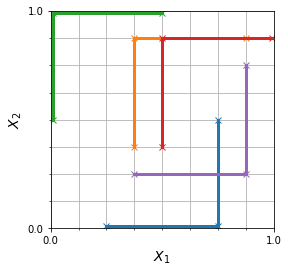

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))
for trajectory in sens.trajectories_physical_space[:5]:
    ax.plot(trajectory[:, 0], trajectory[:, 1], marker='x', linewidth=3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(0., 1. + 0.5 / (sens.levels_number - 1), 1. / (sens.levels_number - 1)), minor=True)
ax.set_xticks([0., 1.], minor=False)
ax.set_xticklabels([0., 1.])
ax.set_yticks(np.arange(0., 1. + 0.5 / (sens.levels_number - 1), 1. / (sens.levels_number - 1)), minor=True)
ax.set_yticks([0., 1.], minor=False)
ax.set_yticklabels([0., 1.])
ax.grid(True, which='both')
ax.set_xlabel(r'$X_{1}$', fontsize=14)
ax.set_ylabel(r'$X_{2}$', fontsize=14)
plt.show()

['a1=0.001', 'a2=99.0']


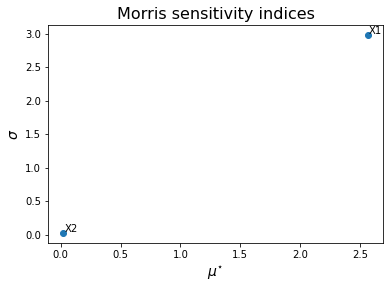

In [6]:
print(['a{}={}'.format(i + 1, ai) for i, ai in enumerate(a_values)])

fig, ax = plt.subplots()
ax.scatter(sens.mustar_indices, sens.sigma_indices)
for i, (mu, sig) in enumerate(zip(sens.mustar_indices, sens.sigma_indices)):
    ax.text(x=mu + 0.01, y=sig + 0.01, s='X{}'.format(i + 1))
ax.set_xlabel(r'$\mu^{\star}$', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_title('Morris sensitivity indices', fontsize=16)
plt.show()

## Test on 12-dimensional g-function

To be compared with results from "An effective screening design for sensitivity analysis of large models", Campolongo et al, 2007

In [7]:
# Set-up problem with g function
a_values = [0.001, 89.9, 5.54, 42.10, 0.78, 1.26, 0.04, 0.79, 74.51, 4.32, 82.51, 41.62]
na = len(a_values)

var_names = ['X{}'.format(i) for i in range(na)]
runmodel_object = RunModel(
    model_script='pfn.py', model_object_name='gfun_sensitivity', var_names=var_names, vec=True, a_values=a_values)

dist_object = [Uniform(), ] * na

In [8]:
sens = MorrisSensitivity(runmodel_object=runmodel_object,
                         distributions=dist_object,
                         levels_number=20,
                         maximize_dispersion=True)
sens.run(trajectories_number=10)

['a1=0.001', 'a2=89.9', 'a3=5.54', 'a4=42.1', 'a5=0.78', 'a6=1.26', 'a7=0.04', 'a8=0.79', 'a9=74.51', 'a10=4.32', 'a11=82.51', 'a12=41.62']


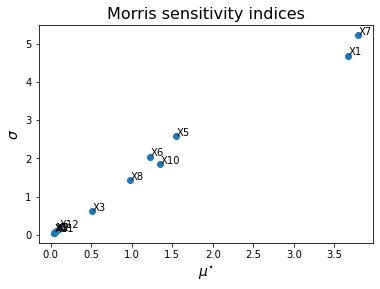

In [9]:
print(['a{}={}'.format(i + 1, ai) for i, ai in enumerate(a_values)])

fig, ax = plt.subplots()
ax.scatter(sens.mustar_indices, sens.sigma_indices)
for i, (mu, sig) in enumerate(zip(sens.mustar_indices, sens.sigma_indices)):
    ax.text(x=mu + 0.01, y=sig + 0.01, s='X{}'.format(i + 1))
ax.set_xlabel(r'$\mu^{\star}$', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_title('Morris sensitivity indices', fontsize=16)
plt.show()

## Test with a function with nonlinearities / parameter dependencies

$$Y = h(X) = 0.01 X_{1} + 1.0 X_{2} + 0.4 X_{3}^{2} + X_{4} X_{5} $$

ranking of input parameters:
- $X_{1}$ is non-influential
- $X_{2}$ is influential, linear/additive effect (expect large $\mu^{\star}$ and small $\sigma$)
- $X_{3}$ is somewhat influential, nonlinear effect, 
- $X_{4}, X_{5}$ are influential with dependence

In [10]:
# Set-up problem with g function

var_names = ['X{}'.format(i) for i in range(5)]
runmodel_object = RunModel(
    model_script='pfn.py', model_object_name='fun2_sensitivity', var_names=var_names, vec=True)

dist_object = [Uniform(), ] * 5

In [11]:
sens = MorrisSensitivity(runmodel_object=runmodel_object,
                         distributions=dist_object,
                         levels_number=20, maximize_dispersion=True)
sens.run(trajectories_number=10)

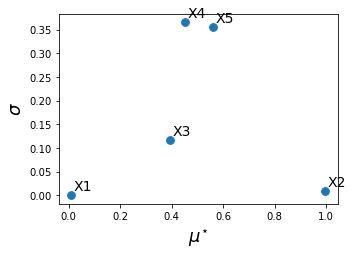

In [12]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.scatter(sens.mustar_indices, sens.sigma_indices, s=60)
for i, (mu, sig) in enumerate(zip(sens.mustar_indices, sens.sigma_indices)):
    ax.text(x=mu + 0.01, y=sig + 0.01, s='X{}'.format(i + 1), fontsize=14)
ax.set_xlabel(r'$\mu^{\star}$', fontsize=18)
ax.set_ylabel(r'$\sigma$', fontsize=18)
# ax.set_title('Morris sensitivity indices', fontsize=16)
plt.show()